# Examples

In [1]:
import numpy as np
from scipy.stats import betabinom, beta as beta_dist

Let's create example count data with following shape

In [2]:
size = (2000, 500)

Ground truth `alpha` and `beta` parameters to sample count data

In [3]:
alpha_true = np.random.random((size[0], 1)) * 10
beta_true = 10 - alpha_true

Sampling counts (`k`) and total counts (`n`) with ground truth 

In [4]:
n = (np.random.random(size) * 1000).astype('int')
k = betabinom.rvs(n, alpha_true * np.ones(size),  beta_true * np.ones(size))

In [5]:
n, k

(array([[676, 199, 449, ..., 907, 535, 474],
        [144, 637, 365, ..., 253,   9, 543],
        [516, 988, 444, ..., 556, 203,  34],
        ...,
        [603, 912, 112, ..., 354, 839, 347],
        [419, 794,  69, ..., 967,  37, 522],
        [155, 274, 586, ...,  72, 312,  92]]),
 array([[576, 145, 449, ..., 897, 519, 446],
        [ 78, 296, 282, ...,  92,   2, 421],
        [372, 352, 368, ..., 341,  96,  16],
        ...,
        [586, 755, 104, ..., 237, 775, 231],
        [ 58, 151,  14, ..., 293,  12, 322],
        [  2,   0,   9, ...,   0,   0,   1]]))

In [6]:
from betabinomial import BetaBinomial

In [7]:
bb = BetaBinomial()

Inference of `alpha` and `beta` parameters from count data

In [8]:
bb.infer(k, n)

 39%|███▊      | 387/1000 [00:27<00:43, 14.25it/s]


BetaBinomial[2000]

Infered `alpha` and `beta`

In [9]:
print(bb.beta)

[[0.96862957]
 [5.58047128]
 [4.29925329]
 ...
 [1.30981972]
 [6.11553939]
 [8.19788565]]


In [10]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 150

Plot true beta distribution mean `(alpha / (alpha + beta))` against inferred

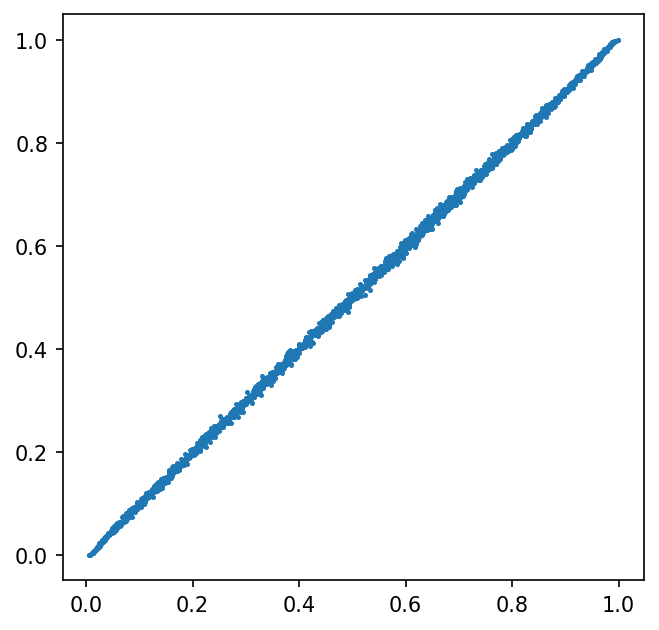

In [11]:
true_beta_mean = alpha_true / (alpha_true + beta_true)
plt.scatter(bb.beta_mean(), true_beta_mean, s=2)

Plot true and predicted `alpha` and `beta` values

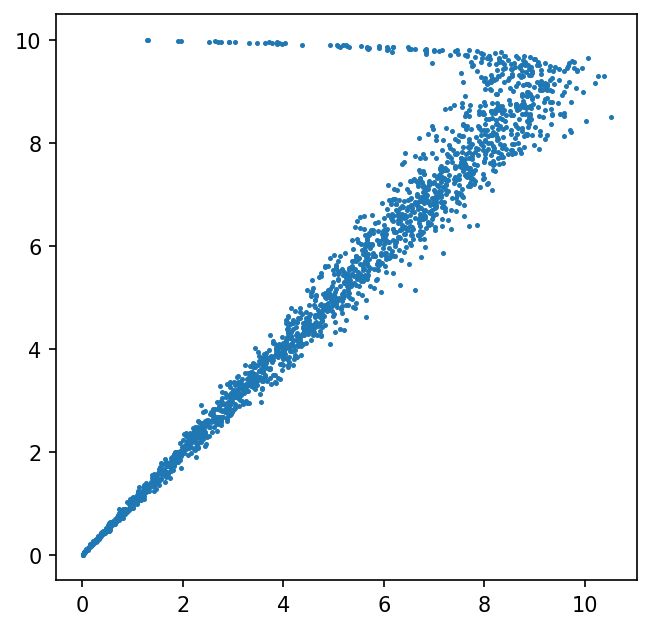

In [12]:
plt.scatter(bb.alpha, alpha_true, s=2)

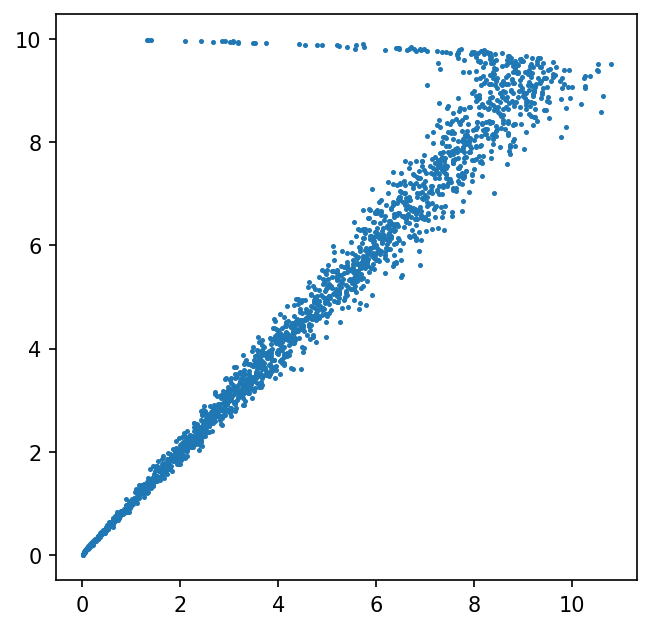

In [13]:
plt.scatter(bb.beta, beta_true, s=2)

Plot a example distribution and true and predicted beta distribution

/home/cs/anaconda3/envs/betabinomial/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


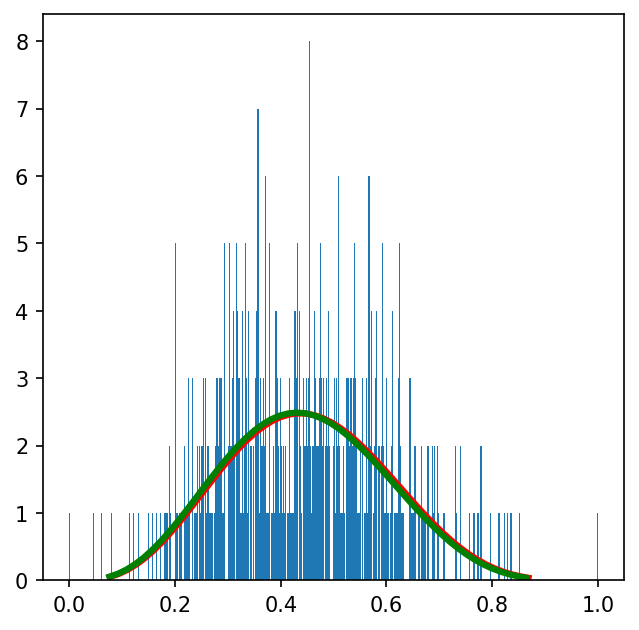

In [14]:
row = np.argwhere((true_beta_mean < 0.8) & (true_beta_mean > 0.2))[0][0]

x = np.linspace(
    beta_dist.ppf(0.001, alpha_true[row], beta_true[row]), 
    beta_dist.ppf(0.999, alpha_true[row], beta_true[row])
)
plt.plot(x, beta_dist.pdf(x, alpha_true[row], beta_true[row]), color='red', linewidth=3)

x = np.linspace(
    beta_dist.ppf(0.001, bb.alpha[row], bb.beta[row]), 
    beta_dist.ppf(0.999, bb.alpha[row], bb.beta[row])
)
plt.hist((k / n)[row, :], bins=500)
plt.plot(x, beta_dist.pdf(x, bb.alpha[row], bb.beta[row]), color='green', linewidth=3)

Plot an example count data and predicted and true beta mean. 

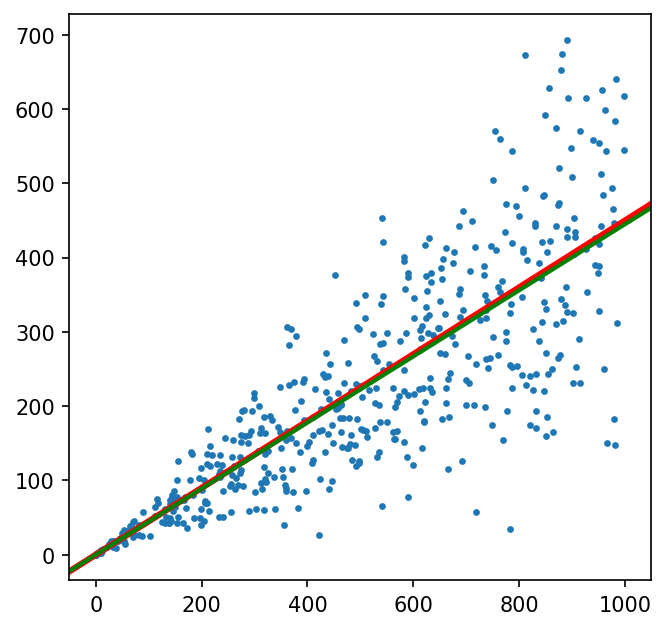

In [15]:
plt.scatter(n[row, :], k[row, :], s=5)
plt.axline((0, 0), slope=alpha_true[row] / (alpha_true[row] + beta_true[row]), color='red', linewidth=3)
plt.axline((0, 0), slope=bb.beta_mean()[row], color='green', linewidth=2)

Perform beta binomial test and return p-values

In [16]:
%%time
pval = bb.pval(k, n, alternative='two-sided') # 'less', 'greater'

CPU times: user 47.6 s, sys: 70.8 ms, total: 47.6 s
Wall time: 47.6 s


In [17]:
pval

array([[0.47071204, 0.1246194 , 0.        , ..., 0.20209759, 0.49338524,
        0.85597761],
       [0.53205675, 0.87959882, 0.02872137, ..., 0.63990266, 0.47873975,
        0.02660131],
       [0.32907127, 0.18101248, 0.06691872, ..., 0.79302436, 0.56091966,
        0.63609345],
       ...,
       [0.25364954, 0.54132593, 0.68948386, ..., 0.09741385, 0.75218964,
        0.0930302 ],
       [0.0905844 , 0.2167264 , 0.31658293, ..., 0.68912332, 0.88179196,
        0.12349764],
       [0.72471544, 0.7938733 , 0.73000221, ..., 0.90094115, 0.76839706,
        0.71438894]])

Multiple testing correction for p-values

In [18]:
from betabinomial import pval_adj

padj = pval_adj(pval)

In [19]:
padj

array([[0.98145199, 0.85917617, 0.        , ..., 0.92728994, 0.98358209,
        0.99879907],
       [0.98712574, 0.9990152 , 0.49263946, ..., 0.99306625, 0.98198   ,
        0.47121168],
       [0.96679745, 0.91456988, 0.73069732, ..., 0.99759152, 0.98909318,
        0.99301005],
       ...,
       [0.94900853, 0.98786424, 0.9950368 , ..., 0.81635475, 0.99645362,
        0.80681572],
       [0.80111808, 0.93467282, 0.96483005, ..., 0.9950368 , 0.9990152 ,
        0.85783098],
       [0.99567023, 0.99759152, 0.995776  , ..., 0.9990152 , 0.99689679,
        0.99559225]])

log-fold change based on the beta-binomial expectation and measured values: 

$$\mu = \frac{n * \alpha}{\alpha + \beta}$$

$$logFC = \log(\frac{k}{\mu})$$

In [20]:
logfc = bb.log_fc(k, n)

/home/cs/Projects/betabinomial/betabinomial/betabinomial.py:152: RuntimeWarning: invalid value encountered in true_divide
  return k / self.mean(n)
/home/cs/Projects/betabinomial/betabinomial/betabinomial.py:162: RuntimeWarning: divide by zero encountered in log
  return np.log(self.fold_change(k, n))


In [21]:
logfc

array([[-0.05617557, -0.21266124,  0.10390984, ...,  0.09282325,
         0.07354698,  0.04302147],
       [ 0.19722547,  0.04391974,  0.55233966, ..., -0.20127097,
        -0.69374745,  0.55585346],
       [ 0.23962961, -0.465209  ,  0.3791009 , ...,  0.07795671,
        -0.18201526, -0.18692928],
       ...,
       [ 0.10768483, -0.05264001,  0.06217426, ..., -0.26495454,
         0.05693456, -0.27062483],
       [-0.99420838, -0.6765841 , -0.61182965, ..., -0.21080636,
        -0.14279174,  0.50010348],
       [-0.86013472,        -inf, -0.68595199, ...,        -inf,
               -inf, -1.03164536]])

z-score based on the beta-binomial mean and variance and measured values:

$$\mu = \frac{n * \alpha}{\alpha + \beta}$$

$$\rho = \frac{1}{1 + \alpha + \beta}$$

$$\sigma^2 = n * \mu * (1 - \mu) * (1 + (n - 1) * \rho)$$

$$ z_{score} = \frac{k - \mu}{\sigma}$$

In [22]:
zscore = bb.z_score(k, n)

/home/cs/Projects/betabinomial/betabinomial/betabinomial.py:202: RuntimeWarning: invalid value encountered in true_divide
  return (k - self.mean(n)) / np.sqrt(self.variance(n))


In [23]:
zscore

array([[-0.53897939, -1.85853045,  1.07650552, ...,  0.96145241,
         0.75159117,  0.43242058],
       [ 0.6270453 ,  0.13252173,  2.16375639, ..., -0.53186857,
        -1.02296894,  2.1913481 ],
       [ 1.01561863, -1.40159935,  1.7263367 , ...,  0.30430112,
        -0.61526846, -0.56794314],
       ...,
       [ 0.99097707, -0.44821678,  0.53963261, ..., -2.01686629,
         0.51184676, -2.05387213],
       [-1.58013725, -1.23985472, -1.08677349, ..., -0.47984339,
        -0.30029588,  1.63123455],
       [-0.30638037, -0.53715367, -0.26878811, ..., -0.51592452,
        -0.53813562, -0.33589806]])

Plot volcona plot with `np.log10(padj)` and `zscore`

/home/cs/anaconda3/envs/betabinomial/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '$\\log_{10}(p_{adj})$')

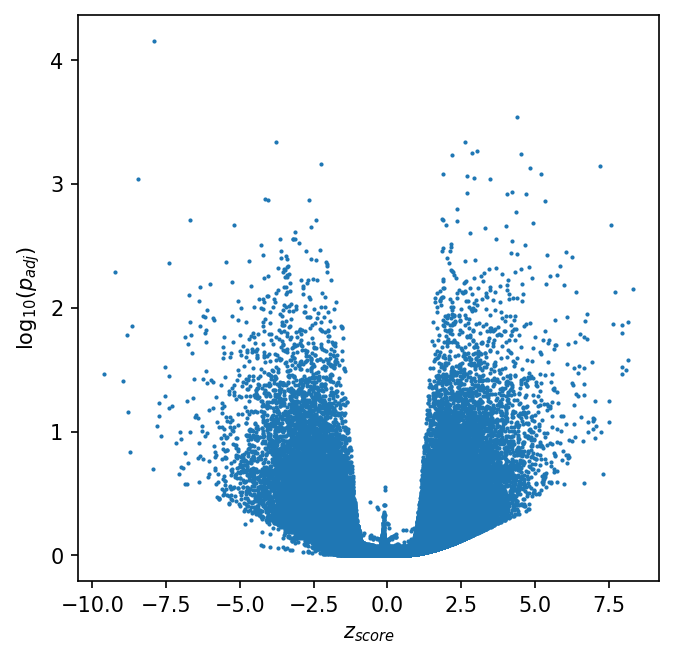

In [24]:
plt.scatter(zscore.ravel(), -np.log10(padj.ravel()), s=1)
plt.xlabel('$z_{score}$')
plt.ylabel('$\log_{10}(p_{adj})$')

Plot volcona plot with `np.log10(padj)` and `logFC`

/home/cs/anaconda3/envs/betabinomial/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '$\\log_{10}(p_{adj})$')

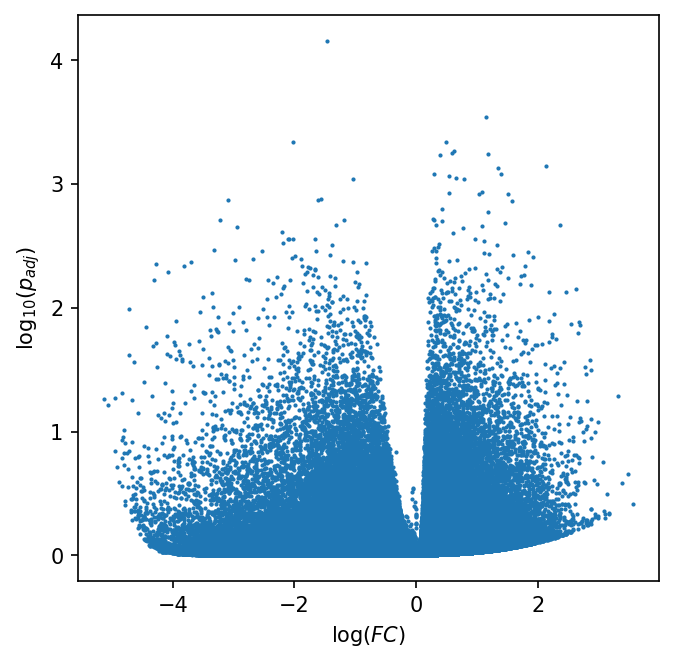

In [25]:
plt.scatter(logfc.ravel(), -np.log10(padj.ravel()), s=1)
plt.xlabel('$\log(FC)$')
plt.ylabel('$\log_{10}(p_{adj})$')